## init

In [4]:
from pyfiles import (parametrics as par,
    complex as cplx,
    matrix as mat,
    vineyard as vin,
    input as inp,
    plot as ourplot,
    grid as grid,
    utils as utils
)

# so we don't have to reboot kernel every time we modify classes.py
%load_ext autoreload
%autoreload 2

import numpy as np
from copy import deepcopy

import matplotlib.pyplot as plt
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


for_each_edge called 30493 times
|======== Timed report ========
| initialize_vineyards            :      13.26ms  (13.257ms per; #1)
| vine_to_vine.ordering           :    9566.09ms  ( 0.380ms per; #25200)
| vine_to_vine.transpositions_lean:    3842.80ms  ( 0.152ms per; #25200)
| vine_to_vine.matrix copies      :   42473.06ms  ( 1.685ms per; #25200)
| low_inv                         :    1133.21ms  ( 0.000ms per; #3226703)
| perform_one_swap case 1         :   16078.75ms  ( 0.005ms per; #3226703)
| perform_one_swap                :   20953.54ms  ( 0.006ms per; #3231486)
| vine_to_vine.loop               :   28305.41ms  ( 1.123ms per; #25200)
| vine_to_vine                    :   84337.40ms  ( 3.347ms per; #25200)
| perform_one_swap case 3         :     324.21ms  ( 0.068ms per; #4783)
| flood_fill_visit                :   84993.62ms  (84993.624ms per; #1)
|==============================


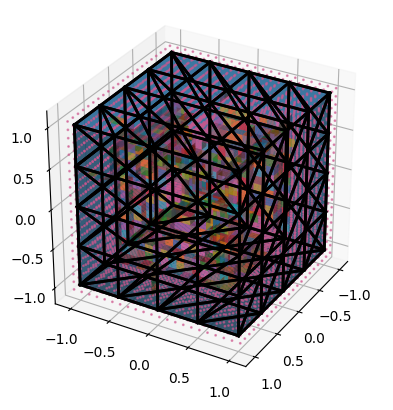

In [43]:
from typing import Tuple, Optional

our_complex = inp.read_obj("input/cube-subdiv-2.obj")
gridd = grid.Grid3.from_complex(our_complex, 0.1, buffer=0.1)

state = {}
faustian_edges = []
bad_points = []
call_count = 0
def for_each_edge(new_point: Tuple[int,int,int], old_point: Optional[Tuple[int, int, int]]):
  global call_count
  n_edge_guess = 6 * gridd.a.shape[0] * gridd.a.shape[1] * gridd.a.shape[2]
  print(f'Progress: {int(100 * call_count / n_edge_guess )}%\r', end='')
  call_count += 1
  if old_point is None:
    if gridd.on_boundary(new_point):
      raise Exception('Dont start on the boundary!')
    special_point_a = gridd.coordinate(new_point)
    state[new_point] = vin.initialize_vineyards(our_complex, special_point_a)
  else:
    if gridd.on_boundary(new_point) and gridd.on_boundary(old_point):
      return
    special_point_b = gridd.coordinate(new_point)
    (D, R, U_t, a_ordering) = state[old_point]
    with utils.Timed('vine_to_vine'):
      (faustian, new_D, new_R, new_U_t, b_ordering, bad_point) = vin.vine_to_vine(
        D, R, U_t, our_complex, special_point_b, a_ordering, 0, prune=True
      )
    if bad_point is not None:
      bad_points.append(bad_point)
    state[new_point] = (new_D, new_R, new_U_t, b_ordering)
    if faustian:
      faustian_edges.append((old_point, new_point))


start_index = gridd.center_index()
with utils.Timed('flood_fill_visit'):
  gridd.flood_fill_visit(start_index, for_each_edge)
print(f'for_each_edge called {call_count} times')

for azim in [30]:
  fig, ax = plt.subplots(subplot_kw={'projection': '3d', 'computed_zorder': False})
  ax.view_init(azim=azim, elev=30)
  ax.set_aspect('equal')
  ourplot.plot_complex_3d(ax, our_complex)
  ourplot.plot_grid_3d(ax, gridd)
  for (a, b) in faustian_edges:
    [a,b,c,d] = gridd.dual_face(a, b)
    ourplot.plot_face_3d(ax, a,b,c,d,)
  ax.plot(
    [p[0] for p in bad_points],
    [p[1] for p in bad_points],
    [p[2] for p in bad_points],
    'o', markersize=5, color='red'
  )
  ax.set_aspect('equal')

with open('output/obj.obj', 'w') as f:
  vi = 1
  for (a, b) in faustian_edges:
    [a, b, c, d] = gridd.dual_face(a, b)
    f.write(f'v {a[0]} {a[1]} {a[2]}\n')
    f.write(f'v {b[0]} {b[1]} {b[2]}\n')
    f.write(f'v {c[0]} {c[1]} {c[2]}\n')
    f.write(f'v {d[0]} {d[1]} {d[2]}\n')
    f.write(f'f {vi + 0} {vi + 1} {vi + 2} {vi + 3}\n')
    vi += 4



utils.Timed.report()

In [42]:
utils.Timed.report()

|======== Timed report ========
| initialize_vineyards            :      52.89ms  (52.885ms per; #1)
| vine_to_vine.ordering           :     518.36ms  ( 1.534ms per; #338)
| vine_to_vine.transpositions_lean:    2665.12ms  ( 7.885ms per; #338)
| vine_to_vine.matrix copies      :    2788.24ms  ( 8.249ms per; #338)
| low_inv                         :     829.13ms  ( 0.000ms per; #2343964)
| perform_one_swap case 1         :   11837.01ms  ( 0.005ms per; #2343964)
| perform_one_swap                :   15376.33ms  ( 0.007ms per; #2344238)
| perform_one_swap case 3         :      63.64ms  ( 0.232ms per; #274)
| vine_to_vine.loop               :   21071.54ms  (62.342ms per; #338)
| vine_to_vine                    :   27142.95ms  (80.305ms per; #338)
| flood_fill_visit                :   27242.46ms  (27242.462ms per; #1)
|==============================


```
|======== Timed report ========
| initialize_vineyards            :      25.15ms  (25.147ms per; #1)
| vine_to_vine.ordering           :      78.21ms  ( 0.326ms per; #240)
| vine_to_vine.transpositions_lean:     282.62ms  ( 1.178ms per; #240)
| vine_to_vine.matrix copies      :     650.50ms  ( 2.710ms per; #240)
| perform_one_swap                :    8943.97ms  ( 0.031ms per; #287419)
| dumb loop here                  :    7880.79ms  ( 0.110ms per; #71908)
| vine_to_vine.loop               :    9360.84ms  (39.003ms per; #240)
|==============================



|======== Timed report ========
| initialize_vineyards            :      24.57ms  (24.566ms per; #1)
| vine_to_vine.ordering           :      76.51ms  ( 0.319ms per; #240)
| vine_to_vine.transpositions_lean:     286.16ms  ( 1.192ms per; #240)
| vine_to_vine.matrix copies      :     665.62ms  ( 2.773ms per; #240)
| perform_one_swap                :    4792.20ms  ( 0.017ms per; #287419)
| dumb loop here                  :    2653.58ms  ( 0.037ms per; #71908)
| vine_to_vine.loop               :    5743.39ms  (23.931ms per; #240)
|==============================
```